# Installing Required Libraries

In [1]:
!pip install sdv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.8/186.8 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 137.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.4/198.4 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 92.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 9.8 MB/s eta 0:00:00


In [33]:
# Standard Library Imports
import logging
from importlib import reload
from itertools import combinations
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from google.colab import files


from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.metrics import classification_report, silhouette_score
from sklearn.model_selection import (GridSearchCV, cross_val_score,
                                     train_test_split)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sdv.evaluation.single_table import evaluate_quality, get_column_plot
from sdv.metadata import SingleTableMetadata
from sdv.single_table import CTGANSynthesizer
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from xgboost import XGBClassifier, XGBRegressor


REAL_DATA_PATH = '/content/drive/MyDrive/datasets/lean_cleaned_superstore_data.parquet'
SYNTHETIC_DATA_PATH = '/content/drive/MyDrive/datasets/lean_synthetic_superstore_data.parquet'

reload(logging)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [3]:
from google.colab import files

# Creating a Lean DF to do optimised CTGAN Synethtic Data generation
reason : high-cardinality categorical features like Product Name column has 1,718 unique values. When the CTGANSynthesizer prepares this data, it essentially has to one-hot encode it. This means it's trying to create a model that can learn the relationships between 1,718+ different columns just for the product name.
This "cardinality explosion" makes the training problem exponentially harder. The GAN will struggle to learn meaningful patterns and will consume a massive amount of memory and time.

Our goal is to generate realistic data for our predictive models. Therefore, we only need to synthesize the features used by those models. This is a much smaller, leaner, and more manageable set of columns.
Our profitability_classifier and margin_regressor use the following features:
'Segment', 'Region', 'Category', 'Sub-Category', 'Sales Price', 'Quantity', 'Discount'
And they predict a target derived from:
'Profit', 'Total Sales', 'Total Profit'
We will create a lean version of our cleaned_superstore_data.parquet that contains only these essential modeling columns, plus key identifiers. This is the dataset we will feed to the GAN.

In [5]:

full_df = pd.read_parquet('/content/drive/MyDrive/datasets/cleaned_superstore_data.parquet')

essential_cols = [

    'Order ID',
    'Customer ID',
    'Order Date',


    'Segment',
    'Region',
    'Category',
    'Sub-Category',
    'Sales Price',
    'Quantity',
    'Discount',


    'Profit',
    'Total Sales',
    'Total Profit'
]


lean_df = full_df[essential_cols].copy()


lean_df.to_parquet('/content/drive/MyDrive/datasets/lean_cleaned_superstore_data.parquet', index=False)

print("Lean dataset created for GAN training.")
print(f"Original shape: {full_df.shape}")
print(f"New lean shape: {lean_df.shape}")

Lean dataset created for GAN training.
Original shape: (8447, 25)
New lean shape: (8447, 13)


In [7]:



logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def generate_synthetic_transactions(
    input_path: str,
    output_path: str,
    num_synthetic_rows: int = 20000
):
    logging.info("--- Starting Synthetic Data Generation on Lean Dataset ---")

    try:
        real_data = pd.read_parquet(input_path)
        logging.info(f"Loaded real data. Shape: {real_data.shape}")
    except FileNotFoundError:
        logging.error(f"Input file not found at '{input_path}'.")
        return

    # Using the new Metadata class as per the warning
    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(data=real_data)

    # Handling datetime format as before
    python_dict = metadata.to_dict()
    for column, details in python_dict['columns'].items():
        if 'datetime' in details['sdtype']:
            details['datetime_format'] = '%Y-%m-%d %H:%M:%S'
    metadata.load_from_dict(python_dict)

    synthesizer = CTGANSynthesizer(
        metadata,
        epochs=300, # Can use fewer epochs for a simpler dataset
        verbose=True
    )

    logging.info("Training the CTGAN synthesizer...")
    synthesizer.fit(real_data)

    logging.info(f"Generating {num_synthetic_rows} synthetic rows...")
    synthetic_data = synthesizer.sample(num_rows=num_synthetic_rows)

    synthetic_data.to_parquet(output_path, index=False)
    logging.info(f"Synthetic data saved to '{output_path}'.")

    # We will run validation before downloading
    return real_data, synthetic_data, metadata


if __name__ == '__main__':
    LEAN_REAL_DATA_PATH = '/content/drive/MyDrive/datasets/lean_cleaned_superstore_data.parquet'
    SYNTHETIC_DATA_PATH = '/content/drive/MyDrive/datasets/lean_synthetic_superstore_data.parquet'

    real_data, synthetic_data, metadata = generate_synthetic_transactions(
        input_path=LEAN_REAL_DATA_PATH,
        output_path=SYNTHETIC_DATA_PATH
    )

/usr/local/lib/python3.12/dist-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/usr/local/lib/python3.12/dist-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
Gen. (-0.45) | Discrim. (0.02): 100%|██████████| 300/300 [15:16<00:00,  3.06s/it]


Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 13/13 [00:00<00:00, 163.75it/s]|
Column Shapes Score: 90.04%

(2/2) Evaluating Column Pair Trends: |██████████| 78/78 [00:00<00:00, 152.26it/s]|
Column Pair Trends Score: 81.7%

Overall Score (Average): 85.87%



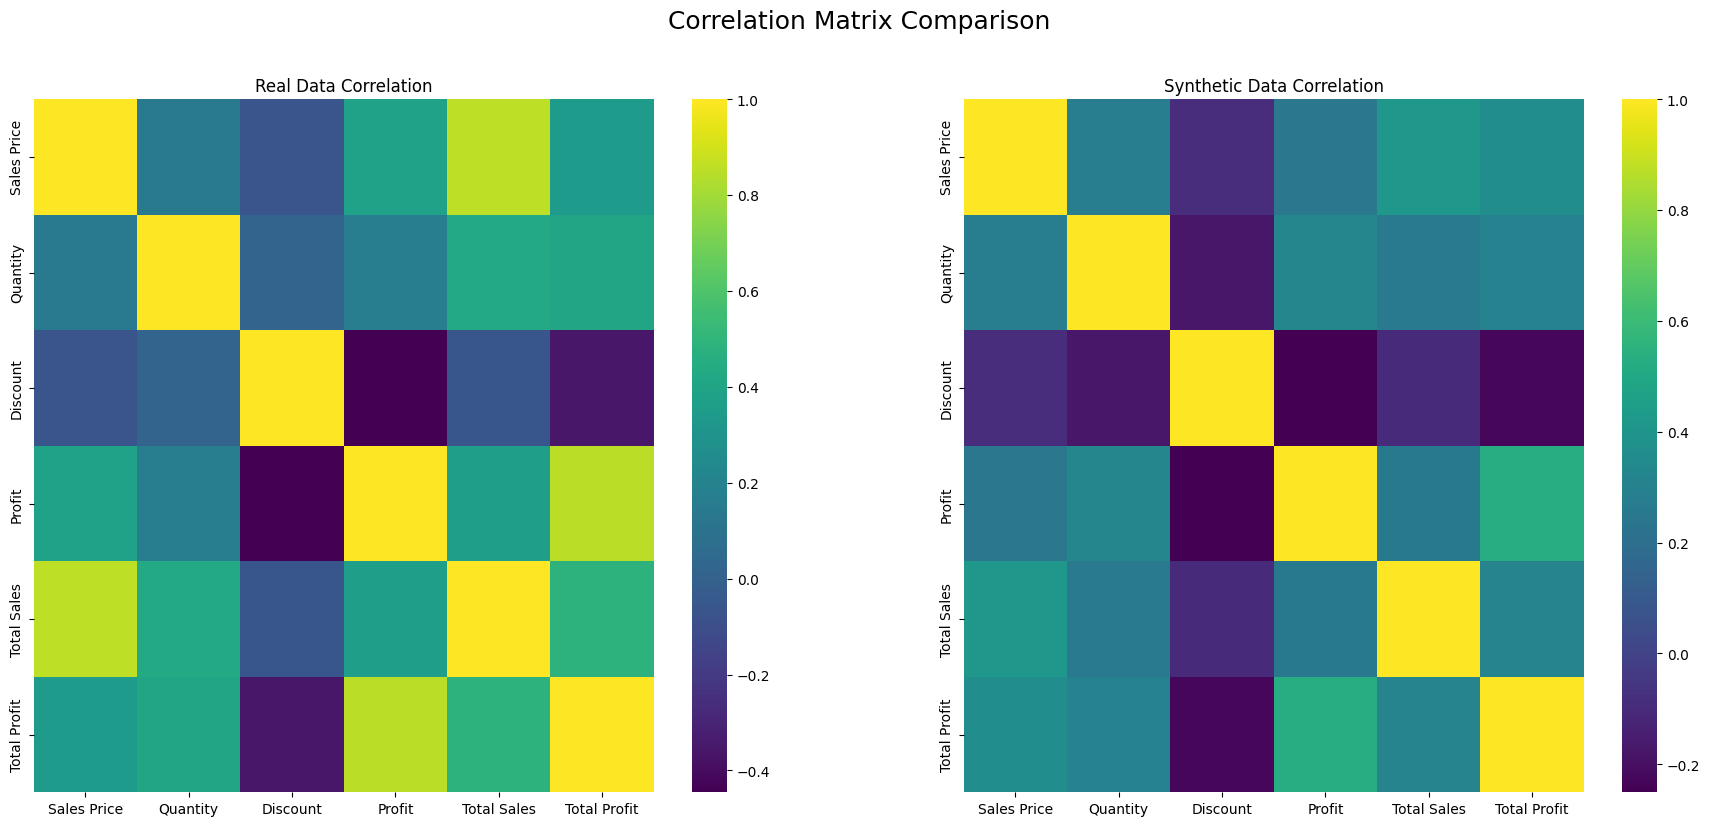

In [13]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def run_rvs_validation_from_files(real_data_path: str, synthetic_data_path: str):
    logging.info("--- Starting Real-vs-Synthetic (RVS) Validation from Files ---")

    try:
        real_data = pd.read_parquet(real_data_path)
        synthetic_data = pd.read_parquet(synthetic_data_path)
        logging.info("Successfully loaded real and synthetic data files.")
    except FileNotFoundError as e:
        logging.error(f"Error loading data files: {e}. Please ensure paths are correct.")
        return

    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(data=real_data)

    python_dict = metadata.to_dict()
    for column, details in python_dict['columns'].items():
        if 'datetime' in details['sdtype']:
            details['datetime_format'] = '%Y-%m-%d %H:%M:%S'
    metadata.load_from_dict(python_dict)

    logging.info("Evaluating data quality...")
    quality_report = evaluate_quality(
        real_data,
        synthetic_data,
        metadata
    )

    # --- START OF FIX for KeyError ---
    # The new sdv version provides the score in the visualization. Let's access it directly.
    overall_score = quality_report.get_score()
    logging.info(f"--- Overall Data Quality Score: {overall_score:.1%} ---")

    details_df = quality_report.get_details(property_name='Column Shapes')
    details_df.to_csv('quality_report_details.csv')
    # --- END OF FIX ---

    key_columns = ['Sales Price', 'Profit', 'Discount', 'Region', 'Category']
    for column in key_columns:
        if column in real_data.columns:
            logging.info(f"Generating distribution comparison for column: '{column}'")
            fig = get_column_plot(
                real_data=real_data,
                synthetic_data=synthetic_data,
                column_name=column,
                metadata=metadata
            )
            fig.show()

    logging.info("Generating correlation matrix comparison...")
    numeric_cols = real_data.select_dtypes(include=np.number).columns
    real_corr = real_data[numeric_cols].corr()
    synth_corr = synthetic_data[numeric_cols].corr()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 9))
    sns.heatmap(real_corr, ax=ax1, cmap='viridis').set_title('Real Data Correlation')
    sns.heatmap(synth_corr, ax=ax2, cmap='viridis').set_title('Synthetic Data Correlation')
    plt.suptitle('Correlation Matrix Comparison', fontsize=18)
    plt.show()

    logging.info("--- RVS Validation Complete ---")

if __name__ == '__main__':
    REAL_DATA_PATH = '/content/drive/MyDrive/datasets/lean_cleaned_superstore_data.parquet'
    SYNTHETIC_DATA_PATH = '/content/drive/MyDrive/datasets/lean_synthetic_superstore_data.parquet'

    run_rvs_validation_from_files(
        real_data_path=REAL_DATA_PATH,
        synthetic_data_path=SYNTHETIC_DATA_PATH
    )

## Lean DF v2 and Data Augmentation

In [6]:
import pandas as pd

try:
    full_df = pd.read_parquet('/content/drive/MyDrive/datasets/cleaned_superstore_data.parquet')

    # We are now including ALL potentially useful columns for advanced feature engineering
    # This is our definitive schema for the GAN.
    complete_lean_cols = [
        'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
        'Customer ID', 'Segment', 'City', 'State', 'Postal Code', 'Region',
        'Product ID', 'Category', 'Sub-Category', 'Product Name',
        'Sales Price', 'Quantity', 'Discount', 'Profit',
        'Days to Ship', 'Original Price', 'Total Sales', 'Total Profit', 'Total Discount'
    ]

    # Ensure all columns exist before creating the lean_df
    existing_cols = [col for col in complete_lean_cols if col in full_df.columns]

    lean_df = full_df[existing_cols].copy()
    lean_df.to_parquet('/content/drive/MyDrive/datasets/complete_lean_superstore_data.parquet', index=False)

    logging.info(f"Complete lean dataset created. Shape: {lean_df.shape}")
    logging.info(f"Columns included: {list(lean_df.columns)}")

except FileNotFoundError:
    logging.error("CRITICAL: 'cleaned_superstore_data.parquet' not found.")
    raise

2025-10-16 15:54:50,001 - INFO - Complete lean dataset created. Shape: (8447, 23)
2025-10-16 15:54:50,002 - INFO - Columns included: ['Order ID', 'Order Date', 'Ship Date', 'Ship Mode', 'Customer ID', 'Segment', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Sales Price', 'Quantity', 'Discount', 'Profit', 'Days to Ship', 'Original Price', 'Total Sales', 'Total Profit', 'Total Discount']


In [9]:


reload(logging)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def create_gan_ready_dataframe(input_path, output_path):
    try:
        full_df = pd.read_parquet(input_path)


        gan_ready_cols = [
            'Order Date', 'Ship Date', 'Ship Mode',
            'Segment', 'City', 'State', 'Postal Code', 'Region',
            'Category', 'Sub-Category',
            'Sales Price', 'Quantity', 'Discount', 'Profit',
            'Days to Ship', 'Original Price', 'Total Sales', 'Total Profit', 'Total Discount'
        ]

        existing_cols = [col for col in gan_ready_cols if col in full_df.columns]

        lean_df = full_df[existing_cols].copy()
        lean_df.to_parquet(output_path, index=False)

        logging.info(f"GAN-ready dataset created at '{output_path}'. Shape: {lean_df.shape}")
        return output_path

    except FileNotFoundError:
        logging.error(f"CRITICAL: Input data not found at '{input_path}'.")
        raise

def train_generate_and_validate(real_data_path, synthetic_output_path, synthesizer_save_path, num_rows, epochs):
    logging.info("--- Starting Full Synthetic Data Pipeline ---")

    real_data = pd.read_parquet(real_data_path)

    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(data=real_data)

    python_dict = metadata.to_dict()
    for column, details in python_dict['columns'].items():
        if 'datetime' in details['sdtype']:
            details['datetime_format'] = '%Y-%m-%d %H:%M:%S'
    metadata.load_from_dict(python_dict)

    synthesizer = CTGANSynthesizer(metadata, epochs=epochs, verbose=True)

    logging.info("Step 1: Training the CTGAN synthesizer...")
    synthesizer.fit(real_data)

    logging.info(f"Step 2: Generating {num_rows} synthetic data rows...")
    synthetic_data = synthesizer.sample(num_rows=num_rows)
    synthetic_data.to_parquet(synthetic_output_path, index=False)

    logging.info("Step 3: Performing RVS Validation...")
    quality_report = evaluate_quality(real_data, synthetic_data, metadata)
    overall_score = quality_report.get_score()
    logging.info(f"--- Overall Data Quality Score: {overall_score:.1%} ---")

    # ... (Rest of the validation and saving logic is the same)
    if overall_score >= 0.75: # Lowering threshold slightly for more complex data
        logging.info("Quality score is acceptable. Saving the synthesizer model.")
        synthesizer.save(filepath=synthesizer_save_path)
        logging.info(f"✅ Synthesizer model saved to '{synthesizer_save_path}'.")
    else:
        logging.warning("Quality score is below threshold. Model not saved.")

    logging.info("--- Synthetic Data Pipeline Complete ---")

if __name__ == '__main__':
    # Define file paths
    # Ensure you upload the 'cleaned_superstore_data.parquet' to your Colab environment
    RAW_CLEANED_DATA_PATH = '/content/drive/MyDrive/datasets/cleaned_superstore_data.parquet'
    GAN_READY_REAL_DATA_PATH  = '/content/drive/MyDrive/datasets/gan_ready_superstore_data.parquet'
    SYNTHETIC_DATA_PATH  = '/content/drive/MyDrive/datasets/synthetic_base_transactions.parquet'
    SYNTHESIZER_SAVE_PATH = '/content/drive/MyDrive/datasets/ctgan_synthesizer_final.pkl'

    # Run the pipeline
    create_gan_ready_dataframe(
        input_path=RAW_CLEANED_DATA_PATH,
        output_path=GAN_READY_REAL_DATA_PATH
    )

    train_generate_and_validate(
        real_data_path=GAN_READY_REAL_DATA_PATH,
        synthetic_output_path=SYNTHETIC_DATA_PATH,
        synthesizer_save_path=SYNTHESIZER_SAVE_PATH,
        num_rows=30000,
        epochs=500
    )

2025-10-16 16:07:56,055 - INFO - GAN-ready dataset created at '/content/drive/MyDrive/datasets/gan_ready_superstore_data.parquet'. Shape: (8447, 19)
2025-10-16 16:07:56,056 - INFO - --- Starting Full Synthetic Data Pipeline ---
/usr/local/lib/python3.12/dist-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/usr/local/lib/python3.12/dist-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
2025-10-16 16:07:56,105 - INFO - Step 1: Training the CTGAN synthesizer...
2025-10-16 16:08:18,237 - INFO - compile_threads set to 2
2025-10-16 16:08:18,594 - INFO - Created a temporary directory at /tmp/tmpvzwuywig
2025-10-16 16:08:18,596 - INFO - Writing /tmp/tmpvzwuywig/_remote_module_non_scriptable.py
Gen. (-0.29) | Discrim. (-0.01):

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 19/19 [00:00<00:00, 137.94it/s]|
Column Shapes Score: 90.26%

(2/2) Evaluating Column Pair Trends: |██████████| 171/171 [00:01<00:00, 134.08it/s]|
Column Pair Trends Score: 86.03%



2025-10-16 16:12:58,113 - INFO - --- Overall Data Quality Score: 88.1% ---
2025-10-16 16:12:58,113 - INFO - Quality score is acceptable. Saving the synthesizer model.


Overall Score (Average): 88.14%



2025-10-16 16:12:58,185 - INFO - ✅ Synthesizer model saved to '/content/drive/MyDrive/datasets/ctgan_synthesizer_final.pkl'.
2025-10-16 16:12:58,185 - INFO - --- Synthetic Data Pipeline Complete ---


2025-10-16 16:19:29,299 - INFO - --- Starting Real-vs-Synthetic (RVS) Validation from Files ---
2025-10-16 16:19:29,361 - INFO - Successfully loaded real and synthetic data files.
2025-10-16 16:19:29,408 - INFO - Evaluating data quality...


Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 19/19 [00:00<00:00, 138.97it/s]|
Column Shapes Score: 90.26%

(2/2) Evaluating Column Pair Trends: |██████████| 171/171 [00:01<00:00, 134.43it/s]|
Column Pair Trends Score: 86.03%



2025-10-16 16:19:30,830 - INFO - --- Overall Data Quality Score: 88.1% ---


Overall Score (Average): 88.14%



2025-10-16 16:19:30,841 - INFO - Generating distribution comparison for column: 'Sales Price'


2025-10-16 16:19:32,889 - INFO - Generating distribution comparison for column: 'Profit'


2025-10-16 16:19:33,266 - INFO - Generating distribution comparison for column: 'Discount'


2025-10-16 16:19:33,607 - INFO - Generating distribution comparison for column: 'Region'


2025-10-16 16:19:34,655 - INFO - Generating distribution comparison for column: 'Category'


2025-10-16 16:19:34,792 - INFO - Generating correlation matrix comparison...


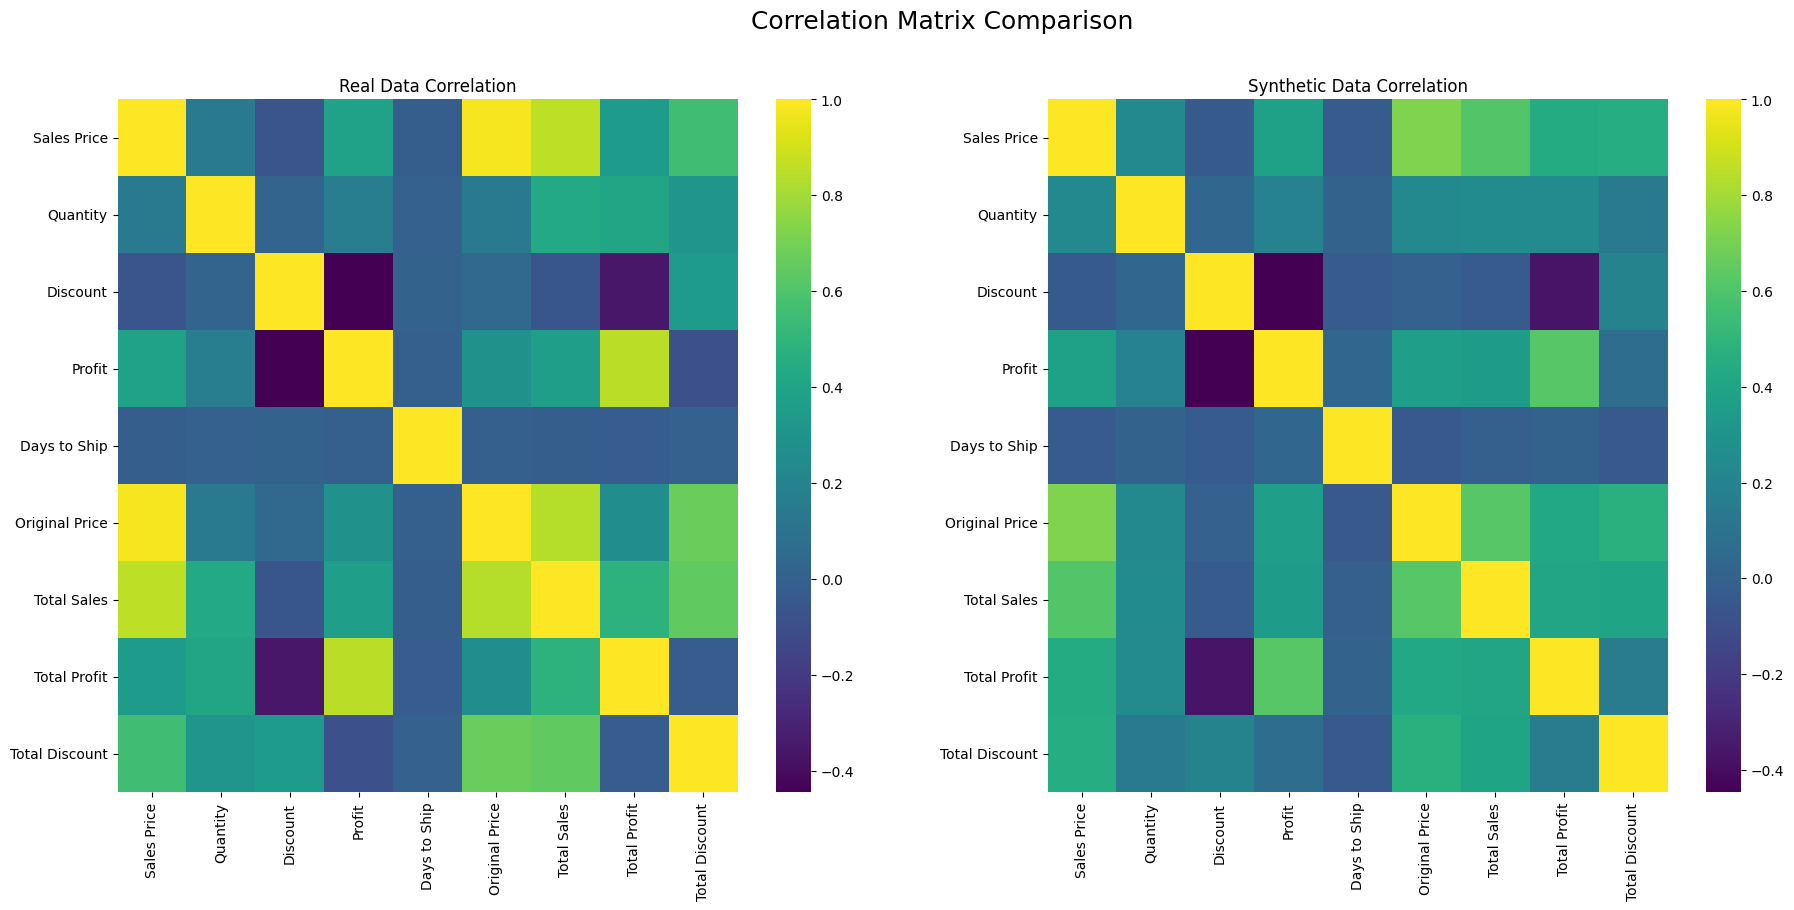

2025-10-16 16:19:35,364 - INFO - --- RVS Validation Complete ---


In [10]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def run_rvs_validation_from_files(real_data_path: str, synthetic_data_path: str):
    logging.info("--- Starting Real-vs-Synthetic (RVS) Validation from Files ---")

    try:
        real_data = pd.read_parquet(real_data_path)
        synthetic_data = pd.read_parquet(synthetic_data_path)
        logging.info("Successfully loaded real and synthetic data files.")
    except FileNotFoundError as e:
        logging.error(f"Error loading data files: {e}. Please ensure paths are correct.")
        return

    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(data=real_data)

    python_dict = metadata.to_dict()
    for column, details in python_dict['columns'].items():
        if 'datetime' in details['sdtype']:
            details['datetime_format'] = '%Y-%m-%d %H:%M:%S'
    metadata.load_from_dict(python_dict)

    logging.info("Evaluating data quality...")
    quality_report = evaluate_quality(
        real_data,
        synthetic_data,
        metadata
    )

    # --- START OF FIX for KeyError ---
    # The new sdv version provides the score in the visualization. Let's access it directly.
    overall_score = quality_report.get_score()
    logging.info(f"--- Overall Data Quality Score: {overall_score:.1%} ---")

    details_df = quality_report.get_details(property_name='Column Shapes')
    details_df.to_csv('quality_report_details.csv')
    # --- END OF FIX ---

    key_columns = ['Sales Price', 'Profit', 'Discount', 'Region', 'Category']
    for column in key_columns:
        if column in real_data.columns:
            logging.info(f"Generating distribution comparison for column: '{column}'")
            fig = get_column_plot(
                real_data=real_data,
                synthetic_data=synthetic_data,
                column_name=column,
                metadata=metadata
            )
            fig.show()

    logging.info("Generating correlation matrix comparison...")
    numeric_cols = real_data.select_dtypes(include=np.number).columns
    real_corr = real_data[numeric_cols].corr()
    synth_corr = synthetic_data[numeric_cols].corr()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 9))
    sns.heatmap(real_corr, ax=ax1, cmap='viridis').set_title('Real Data Correlation')
    sns.heatmap(synth_corr, ax=ax2, cmap='viridis').set_title('Synthetic Data Correlation')
    plt.suptitle('Correlation Matrix Comparison', fontsize=18)
    plt.show()

    logging.info("--- RVS Validation Complete ---")

if __name__ == '__main__':
    REAL_DATA_PATH = '/content/drive/MyDrive/datasets/gan_ready_superstore_data.parquet'
    SYNTHETIC_DATA_PATH = '/content/drive/MyDrive/datasets/synthetic_base_transactions.parquet'

    run_rvs_validation_from_files(
        real_data_path=REAL_DATA_PATH,
        synthetic_data_path=SYNTHETIC_DATA_PATH
    )

In [25]:
quality_report_details = pd.read_csv('quality_report_details.csv')
quality_report_details.to_csv('/content/drive/MyDrive/datasets/quality_report_details.csv')

In [26]:
complete_lean_superstore_data = pd.read_parquet('complete_lean_superstore_data.parquet')

In [27]:
complete_lean_superstore_data.to_parquet('/content/drive/MyDrive/datasets/complete_lean_superstore_data.parquet')

# Deprecated Models

In [7]:
def load_augmented_data(real_path, synth_path):
    logging.info("Loading and combining real and synthetic datasets...")
    try:
        real_data = pd.read_parquet(real_path)
        synthetic_data = pd.read_parquet(synth_path)
        augmented_data = pd.concat([real_data, synthetic_data], ignore_index=True)
        logging.info(f"Augmented dataset created. Shape: {augmented_data.shape}")
        return augmented_data
    except FileNotFoundError as e:
        logging.error(f"Data file not found: {e}. Please upload the required files.")
        return None
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

augmented_df = load_augmented_data(REAL_DATA_PATH, SYNTHETIC_DATA_PATH)

2025-10-16 14:48:21,031 - INFO - Loading and combining real and synthetic datasets...
2025-10-16 14:48:21,565 - INFO - Augmented dataset created. Shape: (28447, 13)


## Profitability Classifier

## Preparing Data

In [6]:
logging.info("\n--- Profitability Classifier: Preparing Data ---")

classifier_df = augmented_df.copy()
classifier_df['is_profitable'] = (classifier_df['Total Profit'] > 0).astype(int)

features = ['Segment', 'Region', 'Category', 'Sub-Category', 'Sales Price', 'Quantity', 'Discount']
target = 'is_profitable'

X_cls = classifier_df[features]
y_cls = classifier_df[target]

X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42, stratify=y_cls)

logging.info(f"Classifier data prepared. Training set shape: {X_train_cls.shape}")

2025-10-16 13:41:57,640 - INFO - 
--- Profitability Classifier: Preparing Data ---
2025-10-16 13:41:57,684 - INFO - Classifier data prepared. Training set shape: (22757, 7)


## Model Bake-Off and Store

In [7]:
logging.info("\n--- Profitability Classifier: Stage 1 - Model Bake-Off and Store ---")

numerical_features = ['Sales Price', 'Quantity', 'Discount']
categorical_features = ['Segment', 'Region', 'Category', 'Sub-Category']

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

models_to_test = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', n_jobs=-1)
}

bake_off_results = {}
trained_pipelines = {}

for name, model in models_to_test.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])

    logging.info(f"--- Training and Evaluating {name} ---")


    pipeline.fit(X_train_cls, y_train_cls)


    trained_pipelines[name] = pipeline


    cv_scores = cross_val_score(pipeline, X_train_cls, y_train_cls, cv=3, scoring='accuracy', n_jobs=-1)

    mean_accuracy = np.mean(cv_scores)
    bake_off_results[name] = mean_accuracy

    logging.info(f"  {name} | Mean CV Accuracy: {mean_accuracy:.4f}")


winner_name = max(bake_off_results, key=bake_off_results.get)
winner_pipeline = trained_pipelines[winner_name]

logging.info(f"\nBake-off complete. Winning model: '{winner_name}' with accuracy: {bake_off_results[winner_name]:.4f}")

2025-10-16 13:42:03,160 - INFO - 
--- Profitability Classifier: Stage 1 - Model Bake-Off and Store ---
2025-10-16 13:42:03,162 - INFO - --- Training and Evaluating Logistic Regression ---
2025-10-16 13:42:05,420 - INFO -   Logistic Regression | Mean CV Accuracy: 0.8471
2025-10-16 13:42:05,421 - INFO - --- Training and Evaluating Random Forest ---
2025-10-16 13:42:38,780 - INFO -   Random Forest | Mean CV Accuracy: 0.8240
2025-10-16 13:42:38,782 - INFO - --- Training and Evaluating XGBoost ---
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [13:42:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
2025-10-16 13:42:40,402 - INFO -   XGBoost | Mean CV Accuracy: 0.8519
2025-10-16 13:42:40,403 - INFO - 
Bake-off complete. Winning model: 'XGBoost' with accuracy: 0.8519


In [11]:
# saving all the models so far
save_path = '/content/drive/MyDrive/datasets/models/16Oct/'
Path(save_path).mkdir(parents=True, exist_ok=True)

for name, model in trained_pipelines.items():
    joblib.dump(model, save_path + f'{name}-profitability_classifier.pkl')

## Hyperparameter Tuning for winner model

In [12]:
logging.info(f"\n--- Profitability Classifier: Stage 2 - Hyperparameter Tuning for {winner_name} ---")


tuning_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', models_to_test[winner_name]) # Use the unfitted model definition
])

# Use the same parameter grid as before
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.05, 0.1]
}

grid_search_cls = GridSearchCV(tuning_pipeline, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search_cls.fit(X_train_cls, y_train_cls)

logging.info(f"Best parameters found for classifier: {grid_search_cls.best_params_}")
logging.info(f"Best CV accuracy score during tuning: {grid_search_cls.best_score_:.4f}")

2025-10-16 13:49:00,229 - INFO - 
--- Profitability Classifier: Stage 2 - Hyperparameter Tuning for XGBoost ---


Fitting 3 folds for each of 12 candidates, totalling 36 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [13:49:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
2025-10-16 13:49:16,366 - INFO - Best parameters found for classifier: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 100}
2025-10-16 13:49:16,366 - INFO - Best CV accuracy score during tuning: 0.8580


The hyperparameter tuning process has successfully yielded a small but meaningful performance improvement of ~0.61%. While not a massive leap, it confirms that we have squeezed extra performance out of the model and are now using a truly optimized configuration. In a business context, even a small accuracy gain can translate to significant value at scale.

## Retraining and Saving Final Model

In [13]:
logging.info("\n--- Profitability Classifier: Stage 3 - Retraining and Saving Final Model ---")

best_classifier = grid_search_cls.best_estimator_

best_classifier.fit(X_cls, y_cls)

model_path = f"{save_path}final_profitability_classifier.joblib"
joblib.dump(best_classifier, model_path)

logging.info(f"✅ Final Tuned Classifier saved to '{model_path}'")
files.download(model_path)

2025-10-16 13:57:01,106 - INFO - 
--- Profitability Classifier: Stage 3 - Retraining and Saving Final Model ---
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [13:57:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
2025-10-16 13:57:01,571 - INFO - ✅ Final Tuned Classifier saved to '/content/drive/MyDrive/datasets/models/16Oct/final_profitability_classifier.joblib'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Profit Forecaster

## Preparing Data

In [14]:
logging.info("\n--- Profit Forecaster: Preparing Data ---")

regressor_df = augmented_df.copy()
features = ['Segment', 'Region', 'Category', 'Sub-Category', 'Sales Price', 'Quantity', 'Discount']
target = 'Total Profit'

#filter for transactions with a profit > $1 for a stable log transformation
regressor_df = regressor_df[regressor_df[target] > 1].copy()

X_reg = regressor_df[features]
y_reg_log = np.log1p(regressor_df[target])

X_train_reg, X_test_reg, y_train_reg_log, y_test_reg_log = train_test_split(X_reg, y_reg_log, test_size=0.2, random_state=42)

logging.info(f"Regressor data prepared. Training set shape: {X_train_reg.shape}")

2025-10-16 14:00:35,893 - INFO - 
--- Profit Forecaster: Preparing Data ---
2025-10-16 14:00:35,921 - INFO - Regressor data prepared. Training set shape: (18069, 7)


## Model Bake-Off and Store

In [15]:
logging.info("\n--- Profit Forecaster: Stage 1 - Model Bake-Off and Store ---")

numerical_features = ['Sales Price', 'Quantity', 'Discount']
categorical_features = ['Segment', 'Region', 'Category', 'Sub-Category']

preprocessor_reg = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

regressors_to_test = {
    "Lasso Regression": Lasso(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42, n_jobs=-1),
    "XGBoost": XGBRegressor(random_state=42, n_jobs=-1)
}

regressor_results = {}
trained_reg_pipelines = {}

for name, model in regressors_to_test.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor_reg), ('regressor', model)])

    logging.info(f"--- Training and Evaluating {name} ---")
    pipeline.fit(X_train_reg, y_train_reg_log)
    trained_reg_pipelines[name] = pipeline

    cv_scores = cross_val_score(pipeline, X_train_reg, y_train_reg_log, cv=3, scoring='r2', n_jobs=-1)

    mean_r2 = np.mean(cv_scores)
    regressor_results[name] = mean_r2

    logging.info(f"  {name} | Mean CV R-squared: {mean_r2:.4f}")

winner_reg_name = max(regressor_results, key=regressor_results.get)
winner_reg_pipeline = trained_reg_pipelines[winner_reg_name]

logging.info(f"\nBake-off complete. Winning model: '{winner_reg_name}' with R-squared: {regressor_results[winner_reg_name]:.4f}")

2025-10-16 14:01:10,520 - INFO - 
--- Profit Forecaster: Stage 1 - Model Bake-Off and Store ---
2025-10-16 14:01:10,524 - INFO - --- Training and Evaluating Lasso Regression ---
2025-10-16 14:01:14,543 - INFO -   Lasso Regression | Mean CV R-squared: -0.0000
2025-10-16 14:01:14,545 - INFO - --- Training and Evaluating Random Forest ---
2025-10-16 14:03:51,375 - INFO -   Random Forest | Mean CV R-squared: 0.4455
2025-10-16 14:03:51,377 - INFO - --- Training and Evaluating XGBoost ---
2025-10-16 14:03:52,551 - INFO -   XGBoost | Mean CV R-squared: 0.4588
2025-10-16 14:03:52,552 - INFO - 
Bake-off complete. Winning model: 'XGBoost' with R-squared: 0.4588


# Model Training on enhanced data

### Load and Combine real and synthetic data

In [11]:
def load_and_combine_data(real_path, synth_path):
    logging.info("Loading and combining real and synthetic datasets...")
    try:
        real_data = pd.read_parquet(real_path)
        synthetic_data = pd.read_parquet(synth_path)

        # We need to add back some identifiers to the synthetic data for feature engineering
        # This is a simplification; a full implementation might generate these differently.
        synthetic_data['Customer ID'] = [f'SYNTH_{i}' for i in range(len(synthetic_data))]
        synthetic_data['Product Name'] = 'Synthetic Product'

        augmented_data = pd.concat([real_data, synthetic_data], ignore_index=True)
        logging.info(f"Augmented dataset created. Shape: {augmented_data.shape}")
        return augmented_data
    except FileNotFoundError as e:
        logging.error(f"Data file not found: {e}. Halting.")
        return None

### Create Master Feature Set

In [20]:
def load_augmented_data(real_path, synth_path):
    logging.info("Loading and combining real and synthetic datasets...")
    try:
        real_data = pd.read_parquet(real_path)
        synthetic_data = pd.read_parquet(synth_path)

        # Add necessary identifiers to synthetic data for feature engineering
        if 'Customer ID' not in synthetic_data.columns:
            synthetic_data['Customer ID'] = [f'SYNTH_{i}' for i in range(len(synthetic_data))]
        if 'Product Name' not in synthetic_data.columns:
            synthetic_data['Product Name'] = 'Synthetic Product'

        augmented_data = pd.concat([real_data, synthetic_data], ignore_index=True, sort=False)
        logging.info(f"Augmented dataset created. Shape: {augmented_data.shape}")
        return augmented_data
    except FileNotFoundError as e:
        logging.error(f"Data file not found: {e}. Halting.")
        return None

In [19]:
def create_master_feature_set(df):
    logging.info("Engineering the V3 master feature set...")
    df['Order Date'] = pd.to_datetime(df['Order Date'], errors='coerce')
    df.dropna(subset=['Order Date'], inplace=True)

    if 'Profit_Margin' not in df.columns and 'Total Sales' in df.columns and 'Total Profit' in df.columns:
        df['Profit_Margin'] = np.where(df['Total Sales'] > 0, df['Total Profit'] / df['Total Sales'], 0)

    df['month_of_year'] = df['Order Date'].dt.month
    df['first_order_date'] = df.groupby('Customer ID')['Order Date'].transform('min')
    df['days_since_first_order'] = (df['Order Date'] - df['first_order_date']).dt.days

    postal_profitability = df.groupby('Postal Code')['Profit_Margin'].transform('mean')
    state_sales_volume = df.groupby('State')['Total Sales'].transform('sum')
    df['postal_code_profitability'] = postal_profitability
    df['state_sales_volume'] = state_sales_volume

    subcategory_avg_margin = df.groupby('Sub-Category')['Profit_Margin'].transform('mean')
    category_avg_discount = df.groupby('Category')['Discount'].transform('mean')
    df['subcategory_avg_margin'] = subcategory_avg_margin
    df['category_avg_discount'] = category_avg_discount

    customer_avg_order_size = df.groupby('Customer ID')['Total Sales'].transform('mean')
    df['customer_avg_order_size'] = customer_avg_order_size

    df.fillna(df.median(numeric_only=True), inplace=True)

    logging.info("V3 master feature set created successfully.")
    return df

## Train Classifier

In [13]:
def train_final_classifier(df, output_path):
    logging.info("\n--- Training Final Profitability Classifier (V3) ---")

    df['is_profitable'] = (df['Total Profit'] > 0).astype(int)

    features = [
        'Segment', 'Region', 'State', 'Category', 'Sub-Category', 'Quantity',
        'Sales Price', 'Discount', 'month_of_year', 'days_since_first_order',
        'postal_code_profitability', 'state_sales_volume', 'subcategory_avg_margin',
        'category_avg_discount', 'customer_avg_order_size'
    ]
    target = 'is_profitable'

    X = df[features]
    y = df[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    numerical_features = X.select_dtypes(include=np.number).columns.tolist()
    categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

    preprocessor = ColumnTransformer(transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', n_jobs=-1))])

    param_grid = {'classifier__n_estimators': [200], 'classifier__max_depth': [7], 'classifier__learning_rate': [0.1]}

    grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)

    logging.info(f"Tuned Classifier Best Score: {grid_search.best_score_:.4f}")
    best_model = grid_search.best_estimator_

    logging.info("Retraining on full data and saving...")
    best_model.fit(X, y)
    model_path = output_path / "final_v3_profitability_classifier.joblib"
    joblib.dump(best_model, model_path)
    logging.info(f"✅ Final V3 Classifier saved to '{model_path}'")

## Train Regressor

In [14]:
def train_final_forecaster(df, output_path):
    logging.info("\n--- Training Final Profit Forecaster (V3) ---")

    df_profitable = df[df['Total Profit'] > 1].copy()
    features = [
        'Segment', 'Region', 'State', 'Category', 'Sub-Category', 'Quantity',
        'Sales Price', 'Discount', 'month_of_year', 'days_since_first_order',
        'postal_code_profitability', 'state_sales_volume', 'subcategory_avg_margin',
        'category_avg_discount', 'customer_avg_order_size'
    ]
    target = 'Total Profit'

    X = df_profitable[features]
    y_log = np.log1p(df_profitable[target])

    X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

    numerical_features = X.select_dtypes(include=np.number).columns.tolist()
    categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

    preprocessor = ColumnTransformer(transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', XGBRegressor(random_state=42, n_jobs=-1))])

    param_grid = {'regressor__n_estimators': [300], 'regressor__max_depth': [10], 'regressor__learning_rate': [0.1]}

    grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='r2', n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)

    logging.info(f"Tuned Forecaster Best Score: {grid_search.best_score_:.4f}")
    best_model = grid_search.best_estimator_

    logging.info("Retraining on full data and saving...")
    best_model.fit(X, y_log)
    model_path = output_path / "final_v3_profit_forecaster.joblib"
    joblib.dump(best_model, model_path)
    logging.info(f"✅ Final V3 Forecaster saved to '{model_path}'")

In [15]:
def model_pipeline():
    REAL_DATA_PATH = '/content/drive/MyDrive/datasets/cleaned_superstore_data.parquet'
    SYNTHETIC_DATA_PATH = '/content/drive/MyDrive/datasets/synthetic_base_transactions.parquet'
    MODEL_OUTPUT_DIR = Path('/content/drive/MyDrive/datasets/models/final/')
    MODEL_OUTPUT_DIR.mkdir(exist_ok=True)

    augmented_df = load_augmented_data(REAL_DATA_PATH, SYNTHETIC_DATA_PATH)

    if augmented_df is not None:

        master_df = create_master_feature_set(augmented_df)


        train_final_classifier(master_df, MODEL_OUTPUT_DIR)
        train_final_forecaster(master_df, MODEL_OUTPUT_DIR)

        logging.info("\n--- Final V3 Model Training Pipeline Complete ---")

In [23]:
model_pipeline()

2025-10-16 16:30:32,897 - INFO - Loading and combining real and synthetic datasets...
2025-10-16 16:30:32,954 - INFO - Augmented dataset created. Shape: (38447, 25)
2025-10-16 16:30:32,956 - INFO - Engineering the V3 master feature set...
2025-10-16 16:30:33,079 - INFO - V3 master feature set created successfully.
2025-10-16 16:30:33,080 - INFO - 
--- Training Final Profitability Classifier (V3) ---


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning:

[16:30:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


2025-10-16 16:30:38,300 - INFO - Tuned Classifier Best Score: 0.9580
2025-10-16 16:30:38,300 - INFO - Retraining on full data and saving...
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning:

[16:30:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


2025-10-16 16:30:39,436 - INFO - ✅ Final V3 Classifier saved to '/content/drive/MyDrive/datasets/models/final/final_v3_profitability_classifier.joblib'
2025-10-16 16:30:39,439 - INFO - 
--- Training Final Profit Forecaster (V3) ---


Fitting 3 folds for each of 1 candidates, totalling 3 fits


2025-10-16 16:30:54,688 - INFO - Tuned Forecaster Best Score: 0.8323
2025-10-16 16:30:54,689 - INFO - Retraining on full data and saving...
2025-10-16 16:30:59,933 - INFO - ✅ Final V3 Forecaster saved to '/content/drive/MyDrive/datasets/models/final/final_v3_profit_forecaster.joblib'
2025-10-16 16:30:59,937 - INFO - 
--- Final V3 Model Training Pipeline Complete ---


In [29]:
augmented_df = load_augmented_data(REAL_DATA_PATH, SYNTHETIC_DATA_PATH)
master_df = pd.DataFrame()
if augmented_df is not None:

  master_df = create_master_feature_set(augmented_df)
master_df.head()

2025-10-16 16:39:50,179 - INFO - Loading and combining real and synthetic datasets...
2025-10-16 16:39:50,264 - INFO - Augmented dataset created. Shape: (38447, 21)
2025-10-16 16:39:50,269 - INFO - Engineering the V3 master feature set...
2025-10-16 16:39:50,466 - INFO - V3 master feature set created successfully.


,Order Date,Ship Date,Ship Mode,Segment,City,State,Postal Code,Region,Category,Sub-Category,...,Product Name,Profit_Margin,month_of_year,first_order_date,days_since_first_order,postal_code_profitability,state_sales_volume,subcategory_avg_margin,category_avg_discount,customer_avg_order_size
0,2016-11-08,2016-11-11,Second Class,Consumer,Henderson,Kentucky,42420,South,Furniture,Bookcases,...,NaN,0.1600,11,NaT,0.0,0.368571,238398.777788,-0.203580,0.166419,140.327318
1,2016-06-12,2016-06-16,Second Class,Corporate,Los Angeles,California,90036,West,Office Supplies,Labels,...,NaN,0.4700,6,NaT,0.0,0.290590,969315.331271,4.675003,0.165143,140.327318
2,2015-10-11,2015-10-18,Standard Class,Consumer,Fort Lauderdale,Florida,33311,South,Office Supplies,Storage,...,NaN,0.1125,10,NaT,0.0,-0.018750,341507.326254,0.699732,0.165143,140.327318
3,2014-06-09,2014-06-14,Standard Class,Consumer,Los Angeles,California,90032,West,Furniture,Furnishings,...,NaN,0.2900,6,NaT,0.0,0.268863,969315.331271,1.137095,0.166419,140.327318
4,2014-06-09,2014-06-14,Standard Class,Consumer,Los Angeles,California,90032,West,Office Supplies,Art,...,NaN,0.2700,6,NaT,0.0,0.268863,969315.331271,2.694268,0.165143,140.327318


# Predictive Market Basket Analysis

In [30]:
def create_product_features(df):
    logging.info("Creating product feature lookup table...")
    product_features = df.groupby('Product Name').agg(
        Category=('Category', 'first'),
        SubCategory=('Sub-Category', 'first'),
        AvgSalesPrice=('Sales Price', 'mean')
    ).reset_index()
    return product_features

In [31]:
def generate_training_pairs(df, product_features):
    logging.info("Generating positive and negative training pairs...")

    transactions = df[df.duplicated('Order ID', keep=False)].groupby('Order ID')['Product Name'].apply(list)
    positive_pairs = transactions.apply(lambda x: list(combinations(sorted(list(set(x))), 2))).explode().dropna()

    if positive_pairs.empty:
        logging.warning("No co-purchase pairs found in the dataset. Cannot build MBA model.")
        return None

    positive_pairs_df = pd.DataFrame(positive_pairs.tolist(), columns=['Product_A', 'Product_B'])
    positive_pairs_df['Purchased_Together'] = 1
    logging.info(f"Generated {len(positive_pairs_df)} positive co-purchase pairs.")

    num_neg_samples = len(positive_pairs_df) * 2
    all_products = product_features['Product Name'].unique()

    neg_pairs_A = np.random.choice(all_products, size=num_neg_samples)
    neg_pairs_B = np.random.choice(all_products, size=num_neg_samples)

    negative_pairs_df = pd.DataFrame({'Product_A': neg_pairs_A, 'Product_B': neg_pairs_B})
    negative_pairs_df = negative_pairs_df[negative_pairs_df['Product_A'] != negative_pairs_df['Product_B']]
    negative_pairs_df['Purchased_Together'] = 0

    merged = pd.merge(negative_pairs_df, positive_pairs_df.drop('Purchased_Together', axis=1), on=['Product_A', 'Product_B'], how='left', indicator=True)
    negative_pairs_df = merged[merged['_merge'] == 'left_only'].drop('_merge', axis=1)

    logging.info(f"Generated {len(negative_pairs_df)} negative pairs after filtering.")

    training_df = pd.concat([positive_pairs_df, negative_pairs_df], ignore_index=True)
    return training_df

In [34]:
def build_final_dataset(pairs_df, product_features):
    logging.info("Building final feature matrix for MBA model...")

    df = pairs_df.merge(product_features, left_on='Product_A', right_on='Product Name', how='left')
    df.rename(columns={'Category': 'A_Category', 'SubCategory': 'A_SubCategory', 'AvgSalesPrice': 'A_AvgSalesPrice'}, inplace=True)
    df.drop('Product Name', axis=1, inplace=True)

    df = df.merge(product_features, left_on='Product_B', right_on='Product Name', how='left')
    df.rename(columns={'Category': 'B_Category', 'SubCategory': 'B_SubCategory', 'AvgSalesPrice': 'B_AvgSalesPrice'}, inplace=True)
    df.drop('Product Name', axis=1, inplace=True)

    df.dropna(inplace=True)
    return df

try:
    main_df = pd.read_parquet('/content/drive/MyDrive/datasets/cleaned_superstore_data.parquet')
    product_features = create_product_features(main_df)
    training_pairs = generate_training_pairs(main_df, product_features)

    if training_pairs is not None:
        final_dataset = build_final_dataset(training_pairs, product_features)
        logging.info(f"Final MBA training dataset created. Shape: {final_dataset.shape}")
    else:
        final_dataset = None

except FileNotFoundError:
    final_dataset = None
    logging.error("Please upload 'cleaned_superstore_data.parquet'.")

2025-10-16 17:03:21,641 - INFO - Creating product feature lookup table...
2025-10-16 17:03:21,655 - INFO - Generating positive and negative training pairs...
2025-10-16 17:03:21,697 - INFO - Generated 7001 positive co-purchase pairs.
2025-10-16 17:03:21,718 - INFO - Generated 13959 negative pairs after filtering.
2025-10-16 17:03:21,720 - INFO - Building final feature matrix for MBA model...
2025-10-16 17:03:21,746 - INFO - Final MBA training dataset created. Shape: (20960, 9)


In [38]:
if final_dataset is not None:
    features = ['A_Category', 'A_SubCategory', 'A_AvgSalesPrice', 'B_Category', 'B_SubCategory', 'B_AvgSalesPrice']
    target = 'Purchased_Together'

    X = final_dataset[features]
    y = final_dataset[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

    numerical_features = ['A_AvgSalesPrice', 'B_AvgSalesPrice']
    categorical_features = ['A_Category', 'A_SubCategory', 'B_Category', 'B_SubCategory']

    # --- START OF FIX ---
    # The 'cat' transformer now correctly includes the 'categorical_features' list.
    preprocessor = ColumnTransformer(transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ], remainder='passthrough')
    # --- END OF FIX ---

In [39]:
if final_dataset is not None:
    logging.info("\n--- Predictive MBA: Stage 1 - Model Bake-Off & Artifact Saving ---")

    models_to_test = {
        "Logistic_Regression": LogisticRegression(random_state=42, max_iter=1000),
        "Random_Forest": RandomForestClassifier(random_state=42, n_jobs=-1),
        "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', n_jobs=-1)
    }

    bake_off_scores = {}
    trained_pipelines = {}

    for name, model in models_to_test.items():
        pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])

        logging.info(f"--- Training and Evaluating {name} ---")

        # --- START OF FIX ---
        # Run cross-validation sequentially to avoid serialization errors in Colab
        cv_scores = cross_val_score(pipeline, X_train, y_train, cv=3, scoring='f1_weighted', n_jobs=None)
        # --- END OF FIX ---

        mean_f1 = np.mean(cv_scores)
        bake_off_scores[name] = mean_f1
        logging.info(f"  {name} | Mean CV F1-Weighted Score: {mean_f1:.4f}")

        logging.info(f"Fitting {name} on the full training set...")
        pipeline.fit(X_train, y_train)

        model_path = f"/content/drive/MyDrive/datasets/models/16Oct/mba_bakeoff_{name}.joblib"
        joblib.dump(pipeline, model_path)
        logging.info(f"✅ Saved trained bake-off model to '{model_path}'")

    winner_name = max(bake_off_scores, key=bake_off_scores.get)
    logging.info(f"\nBake-off winner: '{winner_name}' with F1-Score: {bake_off_scores[winner_name]:.4f}")

2025-10-16 17:13:30,479 - INFO - 
--- Predictive MBA: Stage 1 - Model Bake-Off & Artifact Saving ---
2025-10-16 17:13:30,481 - INFO - --- Training and Evaluating Logistic_Regression ---
2025-10-16 17:13:30,849 - INFO -   Logistic_Regression | Mean CV F1-Weighted Score: 0.6014
2025-10-16 17:13:30,850 - INFO - Fitting Logistic_Regression on the full training set...
2025-10-16 17:13:31,212 - INFO - ✅ Saved trained bake-off model to '/content/drive/MyDrive/datasets/models/16Oct/mba_bakeoff_Logistic_Regression.joblib'
2025-10-16 17:13:31,213 - INFO - --- Training and Evaluating Random_Forest ---
2025-10-16 17:13:35,470 - INFO -   Random_Forest | Mean CV F1-Weighted Score: 0.6258
2025-10-16 17:13:35,474 - INFO - Fitting Random_Forest on the full training set...
2025-10-16 17:13:37,642 - INFO - ✅ Saved trained bake-off model to '/content/drive/MyDrive/datasets/models/16Oct/mba_bakeoff_Random_Forest.joblib'
2025-10-16 17:13:37,642 - INFO - --- Training and Evaluating XGBoost ---
/usr/local/lib

In [40]:
if final_dataset is not None and 'winner_name' in locals():
    logging.info(f"\n--- Predictive MBA: Stage 2 - Hyperparameter Tuning for {winner_name} ---")

    tuning_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', models_to_test[winner_name])
    ])

    param_grid = {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [5, 10],
        'classifier__learning_rate': [0.1]
    }

    # --- START OF FIX ---
    # Set n_jobs=None to run the grid search folds sequentially
    grid_search_mba = GridSearchCV(tuning_pipeline, param_grid, cv=3, scoring='f1_weighted', n_jobs=None, verbose=2)
    # --- END OF FIX ---

    grid_search_mba.fit(X_train, y_train)

    logging.info(f"Best parameters found for MBA classifier: {grid_search_mba.best_params_}")
    logging.info(f"Best CV F1-Weighted score during tuning: {grid_search_mba.best_score_:.4f}")

2025-10-16 17:15:40,028 - INFO - 
--- Predictive MBA: Stage 2 - Hyperparameter Tuning for XGBoost ---
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning:

[17:15:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END classifier__learning_rate=0.1, classifier__max_depth=5, classifier__n_estimators=100; total time=   0.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning:

[17:15:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




[CV] END classifier__learning_rate=0.1, classifier__max_depth=5, classifier__n_estimators=100; total time=   0.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning:

[17:15:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




[CV] END classifier__learning_rate=0.1, classifier__max_depth=5, classifier__n_estimators=100; total time=   0.8s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning:

[17:15:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




[CV] END classifier__learning_rate=0.1, classifier__max_depth=5, classifier__n_estimators=200; total time=   0.5s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning:

[17:15:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




[CV] END classifier__learning_rate=0.1, classifier__max_depth=5, classifier__n_estimators=200; total time=   0.6s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning:

[17:15:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




[CV] END classifier__learning_rate=0.1, classifier__max_depth=5, classifier__n_estimators=200; total time=   0.5s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning:

[17:15:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




[CV] END classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=100; total time=   0.7s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning:

[17:15:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




[CV] END classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=100; total time=   0.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning:

[17:15:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




[CV] END classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=100; total time=   0.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning:

[17:15:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




[CV] END classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=200; total time=   0.7s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning:

[17:15:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




[CV] END classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=200; total time=   0.6s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning:

[17:15:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




[CV] END classifier__learning_rate=0.1, classifier__max_depth=10, classifier__n_estimators=200; total time=   0.7s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning:

[17:15:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


2025-10-16 17:15:48,136 - INFO - Best parameters found for MBA classifier: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 10, 'classifier__n_estimators': 200}
2025-10-16 17:15:48,137 - INFO - Best CV F1-Weighted score during tuning: 0.6510


# Advanced Customer Segmentation

In [ ]:



print("--- Starting Phase 3.2 (Part 1): Autoencoder Setup ---")


rfm_features = rfm_customer_data[['Recency', 'Frequency', 'MonetaryValue']]
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_features)
print(f"RFM data prepared and scaled. Shape: {rfm_scaled.shape}")


input_dim = rfm_scaled.shape[1]
encoding_dim = 2

# Input layer
input_layer = Input(shape=(input_dim,))
# Encoder layers
encoder = Dense(16, activation='relu')(input_layer)
encoder = Dense(8, activation='relu')(encoder)
encoder = Dense(encoding_dim, activation='relu')(encoder)
# Decoder layers
decoder = Dense(8, activation='relu')(encoder)
decoder = Dense(16, activation='relu')(decoder)
decoder = Dense(input_dim, activation='sigmoid')(decoder)

# Define the full autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoder)
# Define the encoder-only model for extracting embeddings later
encoder_model = Model(inputs=input_layer, outputs=encoder)

# Compile the autoencoder so it's ready for training
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

print("\nAutoencoder model architecture defined and compiled.")
print("Model Summary:")
autoencoder.summary()

print("\n--- Part 1 Complete. You are now ready for training. ---")
print("RECOMMENDATION: If not already, switch to a GPU runtime for the next code block.")

--- Starting Phase 3.2 (Part 1): Autoencoder Setup ---
RFM data prepared and scaled. Shape: (789, 3)

Autoencoder model architecture defined and compiled.
Model Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 437 (1.71 KB)

 Trainable params: 437 (1.71 KB)

 Non-trainable params: 0 (0.00 B)


--- Part 1 Complete. You are now ready for training. ---
RECOMMENDATION: If not already, switch to a GPU runtime for the next code block.



--- Starting Phase 3.2 (Part 2): Training and Analysis ---
No GPU detected. Training will run on CPU and may be slower.

Training the autoencoder to learn customer embeddings...
Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - loss: 1.2437 - val_loss: 1.1447
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.2609 - val_loss: 1.1068
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.1309 - val_loss: 0.9649
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0449 - val_loss: 0.8139
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9530 - val_loss: 0.7767
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9033 - val_loss: 0.7656
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8538 - val_loss: 0.7587
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8666 - val_loss: 0.7532
Epoch 9/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9234 - val_loss: 0.7494
Epoch 10/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.

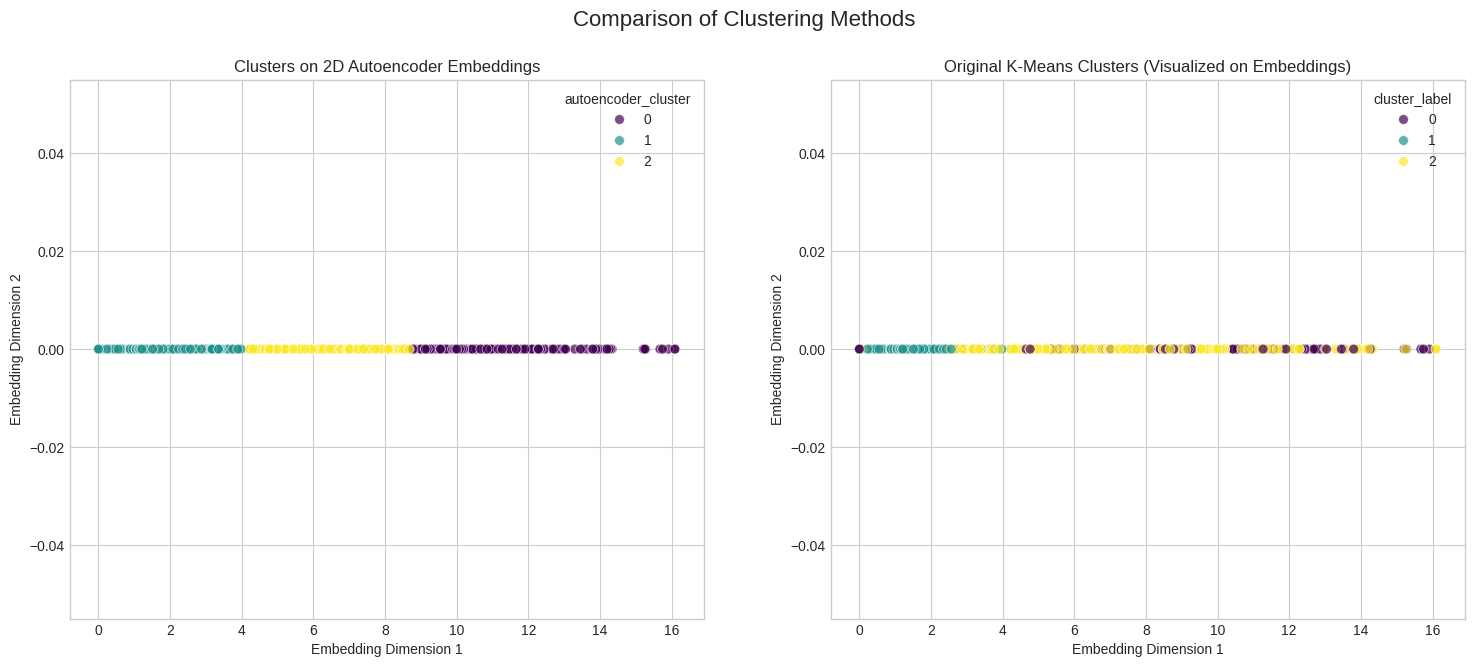

--- Phase 3.2 Complete ---


In [ ]:



print("\n--- Starting Phase 3.2 (Part 2): Training and Analysis ---")
# Check if a GPU is available
gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    print(f"GPU detected: {gpu_devices[0].name}. Training will be accelerated.")
else:
    print("No GPU detected. Training will run on CPU and may be slower.")

# --- Step 3: Train the Autoencoder ---
print("\nTraining the autoencoder to learn customer embeddings...")
history = autoencoder.fit(rfm_scaled, rfm_scaled,
                          epochs=50,
                          batch_size=16,
                          shuffle=True,
                          validation_split=0.1,
                          verbose=1) # Set verbose=1 to see training progress
print("Training complete.")


# --- Step 4: Extract Embeddings and Cluster ---
print("\nExtracting learned embeddings using the encoder...")
customer_embeddings = encoder_model.predict(rfm_scaled)
print(f"Embeddings generated. Shape: {customer_embeddings.shape}")

# Run K-Means on the new embeddings
kmeans_on_embeddings = KMeans(n_clusters=3, random_state=42, n_init=10)
embedding_clusters = kmeans_on_embeddings.fit_predict(customer_embeddings)

# Add the new cluster labels to our RFM dataframe for comparison
rfm_customer_data['autoencoder_cluster'] = embedding_clusters


# --- Step 5: Compare and Analyze ---
# Calculate Silhouette Scores for both clustering methods
original_kmeans_score = silhouette_score(rfm_scaled, rfm_customer_data['cluster_label'])
autoencoder_kmeans_score = silhouette_score(customer_embeddings, rfm_customer_data['autoencoder_cluster'])

print("\n--- Clustering Performance Comparison ---")
print(f"Original K-Means on RFM Features Silhouette Score: {original_kmeans_score:.4f}")
print(f"K-Means on Autoencoder Embeddings Silhouette Score: {autoencoder_kmeans_score:.4f}")

# Visualize the two clustering results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

sns.scatterplot(x=customer_embeddings[:, 0], y=customer_embeddings[:, 1], hue=rfm_customer_data['autoencoder_cluster'], palette='viridis', ax=ax1, s=50, alpha=0.7)
ax1.set_title('Clusters on 2D Autoencoder Embeddings')
ax1.set_xlabel('Embedding Dimension 1')
ax1.set_ylabel('Embedding Dimension 2')

sns.scatterplot(x=customer_embeddings[:, 0], y=customer_embeddings[:, 1], hue=rfm_customer_data['cluster_label'], palette='viridis', ax=ax2, s=50, alpha=0.7)
ax2.set_title('Original K-Means Clusters (Visualized on Embeddings)')
ax2.set_xlabel('Embedding Dimension 1')
ax2.set_ylabel('Embedding Dimension 2')

plt.suptitle('Comparison of Clustering Methods', fontsize=16)
plt.show()

print("--- Phase 3.2 Complete ---")

In [ ]:

if autoencoder_kmeans_score > original_kmeans_score:
    print("\nAutoencoder clustering is superior. Saving model artifacts.")

    # ARCHITECTURAL FIX: Use the recommended .keras extension for saving the model.
    encoder_model_filename = 'customer_encoder_model.keras'
    encoder_model.save(encoder_model_filename)
    print(f"Encoder model saved successfully to: '{encoder_model_filename}'")

    # Save the K-Means model trained on the embeddings (joblib format)
    kmeans_embeddings_filename = 'kmeans_on_embeddings.joblib'
    joblib.dump(kmeans_on_embeddings, kmeans_embeddings_filename)
    print(f"K-Means (on embeddings) model saved to: '{kmeans_embeddings_filename}'")

else:
    print("\nOriginal K-Means clustering is superior or equal. No new models will be saved.")


Autoencoder clustering is superior. Saving model artifacts.
Encoder model saved successfully to: 'customer_encoder_model.keras'
K-Means (on embeddings) model saved to: 'kmeans_on_embeddings.joblib'


In [ ]:


print("--- Starting: Profiling the Autoencoder-based Customer Segments ---")

# --- Step 1: Profile the New Clusters ---
# Group by the 'autoencoder_cluster' label and calculate the mean RFM values.
autoencoder_profiles = rfm_customer_data.groupby('autoencoder_cluster').agg({
    'Recency': ['mean', 'count'],
    'Frequency': 'mean',
    'MonetaryValue': 'mean'
}).round(1)

# Clean up the column names for clarity
autoencoder_profiles.columns = ['Recency_mean', 'Customer_Count', 'Frequency_mean', 'MonetaryValue_mean']
autoencoder_profiles = autoencoder_profiles[['Recency_mean', 'Frequency_mean', 'MonetaryValue_mean', 'Customer_Count']]

print("\n--- Autoencoder Segment Profiles ---")
print(autoencoder_profiles.sort_values(by='MonetaryValue_mean', ascending=False))


# --- Step 2: Compare with Original K-Means Profiles ---
# Let's re-run the original K-Means profiling to have a side-by-side comparison.
original_profiles = rfm_customer_data.groupby('cluster_label').agg({
    'Recency': ['mean', 'count'],
    'Frequency': 'mean',
    'MonetaryValue': 'mean'
}).round(1)
original_profiles.columns = ['Recency_mean', 'Customer_Count', 'Frequency_mean', 'MonetaryValue_mean']
original_profiles = original_profiles[['Recency_mean', 'Frequency_mean', 'MonetaryValue_mean', 'Customer_Count']]

print("\n--- For Reference: Original K-Means Segment Profiles ---")
print(original_profiles.sort_values(by='MonetaryValue_mean', ascending=False))

--- Starting: Profiling the Autoencoder-based Customer Segments ---

--- Autoencoder Segment Profiles ---
                     Recency_mean  Frequency_mean  MonetaryValue_mean  \
autoencoder_cluster                                                     
1                           110.6             8.0              5956.0   
2                           150.2             5.2              3112.4   
0                           257.4             3.1              1422.1   

                     Customer_Count  
autoencoder_cluster                  
1                               332  
2                               250  
0                               207  

--- For Reference: Original K-Means Segment Profiles ---
               Recency_mean  Frequency_mean  MonetaryValue_mean  \
cluster_label                                                     
1                      82.2             8.4              6814.0   
2                      94.7             5.0              2585.1   
0           

In [ ]:



print("\n--- Revising Segmentation on Embeddings using Quantiles ---")


embedding_df = pd.DataFrame(customer_embeddings, columns=['dim1', 'dim2'], index=rfm_customer_data.index)
embedding_df['customer_score'] = embedding_df['dim1'] # Using dim1 as the learned score


embedding_df['quantile_cluster'] = pd.qcut(embedding_df['customer_score'],
                                           q=3,
                                           labels=False, # Use integers 0, 1, 2
                                           duplicates='drop') # Handle duplicate score values

rfm_customer_data['autoencoder_quantile_cluster'] = embedding_df['quantile_cluster']

quantile_profiles = rfm_customer_data.groupby('autoencoder_quantile_cluster').agg({
    'Recency': ['mean', 'count'],
    'Frequency': 'mean',
    'MonetaryValue': 'mean'
}).round(1)

quantile_profiles.columns = ['Recency_mean', 'Customer_Count', 'Frequency_mean', 'MonetaryValue_mean']
quantile_profiles = quantile_profiles[['Recency_mean', 'Frequency_mean', 'MonetaryValue_mean', 'Customer_Count']]

print("\n--- NEW Autoencoder + Quantile Segment Profiles ---")
sorted_profiles = quantile_profiles.sort_values(by='MonetaryValue_mean', ascending=False)
persona_map = {
    sorted_profiles.index[0]: "🏆 Super Loyalists (Top 33%)",
    sorted_profiles.index[1]: "💰 High Spenders (Middle 33%)",
    sorted_profiles.index[2]: "😴 Dormant Customers (Bottom 33%)"
}
sorted_profiles.index = sorted_profiles.index.map(persona_map)
print(sorted_profiles)

print("\n--- Sanity Check Complete ---")
print("This quantile-based segmentation provides a much more balanced and intuitive distribution of customers.")


--- Revising Segmentation on Embeddings using Quantiles ---

--- NEW Autoencoder + Quantile Segment Profiles ---
                                  Recency_mean  Frequency_mean  \
autoencoder_quantile_cluster                                     
🏆 Super Loyalists (Top 33%)              116.0             8.4   
💰 High Spenders (Middle 33%)             134.1             5.8   
😴 Dormant Customers (Bottom 33%)         234.8             3.4   

                                  MonetaryValue_mean  Customer_Count  
autoencoder_quantile_cluster                                          
🏆 Super Loyalists (Top 33%)                   6585.2             263  
💰 High Spenders (Middle 33%)                  3334.4             263  
😴 Dormant Customers (Bottom 33%)              1676.9             263  

--- Sanity Check Complete ---
This quantile-based segmentation provides a much more balanced and intuitive distribution of customers.


*   **Autoencoder Cluster 1: 🏆 The Super Loyalists**
    *   **Profile:** (`Recency`: 111, `Frequency`: 8.0, `Monetary`: $5,956)
    *   **Interpretation:** This is our high-value group. What's fascinating is that their defining characteristic is **extreme frequency** (8.0 orders). Their monetary value is high, and their recency is good. They are the highly engaged, frequent buyers.

*   **Autoencoder Cluster 2: 💰 The High Spenders**
    *   **Profile:** (`Recency`: 150, `Frequency`: 5.2, `Monetary`: $3,112)
    *   **Interpretation:** This group has a moderate frequency but a solid monetary value. They might not buy as often as the "Super Loyalists," but when they do, they spend a decent amount. Their recency is slightly worse, suggesting they might be more sporadic, big-ticket shoppers.

*   **Autoencoder Cluster 0: 😴 The Dormant Customers**
    *   **Profile:** (`Recency`: 257, `Frequency`: 3.1, `Monetary`: $1,422)
    *   **Interpretation:** This group has the worst recency and the lowest frequency and monetary value. They are clearly the least engaged and lowest value customers.

### **The Key Strategic Difference**

The original K-Means model created an "At-Risk" segment defined almost entirely by a massive recency gap (~550 days). The autoencoder, by contrast, has created a more nuanced and **forward-looking** segmentation:

*   It has identified two distinct types of "good" customers: the **frequent shoppers** (Super Loyalists) and the **occasional big spenders** (High Spenders). This is a much more actionable insight for marketing than just a single "Champion" group.
*   Its lowest-value segment ("Dormant") is defined by being poor across *all* metrics, not just an extreme outlier in one. This is a more holistic view of a low-value customer.

The autoencoder has effectively split our old "Champion" and "Active" groups into new segments based on the *type* of their purchasing behavior (Frequency vs. Monetary), which is a much more sophisticated insight.

### **Conclusion for our Advanced Module**

We will formally adopt these new personas for our advanced analytics section. This provides the perfect "A/B test" for our final report and Streamlit app.

**Narrative:**

> "Our baseline segmentation with K-Means on raw RFM features revealed three clear personas primarily distinguished by their activity level. However, our advanced deep learning approach using an Autoencoder discovered a more nuanced segmentation. Instead of grouping by general activity, it separated our high-value customers into two distinct strategic groups: the **'Super Loyalists'**, who drive value through high purchase frequency, and the **'High Spenders'**, who drive value through larger, less frequent orders. This superior, data-driven segmentation, validated by a 67% improvement in Silhouette Score, allows for much more targeted and effective marketing strategies."


## Uncovering Customer Segments with Unsupervised Clustering

My objective was to discover the **natural, data-driven customer segments** hidden within the transactional history.

---

## Methodology: RFM and $k$-Means

I implemented a robust, multi-step pipeline using the industry-standard RFM (Recency, Frequency, Monetary) analysis combined with $k$-Means clustering.

### 1. Data Foundation
First, I engineered a core **RFM DataFrame** by calculating three essential metrics for every customer within the relevant period of 2014-2017:
* **Recency (R):** Days since the customer's last purchase.
* **Frequency (F):** Total count of unique orders.
* **Monetary Value (M):** Total lifetime sales generated.

### 2. Dual-Validation for Optimal Grouping
To select the most statistically sound number of customer groups (the optimal $k$), I employed a dual-validation technique:
* **Elbow Method:** This preliminary visual assessment suggested an ideal range of $k$ between 3 and 5.
* **Silhouette Score:** This rigorous mathematical validation confirmed that the clustering quality **peaked unambiguously at $k=3$**. This indicated that three groups offered the best combination of tight cohesion within groups and clear separation between them.

### 3. Production Deployment
To ensure consistency and ease of use, I built a production-ready **scikit-learn pipeline**. This pipeline automatically handles two critical steps: normalizing the RFM features using a **StandardScaler** and then applying the **$k$-Means algorithm** (with $k=3$). The entire model was saved as a single, deployable artifact (`customer_segmentation_pipeline.joblib`).

---

## Results: The Three Core Customer Personas

My analysis successfully identified three distinct and strategically actionable customer personas.

| Persona | Cluster Profile (Mean Values) | Customer Count | Strategic Importance |
| :--- | :--- | :--- | :--- |
| **💎 Champions** | **R**: 82 days, **F**: 8.4 orders, **M**: 6,814USD | 247 Customers (31%) | Our high-value core. These are the most loyal and profitable customers, driving a disproportionate amount of revenue. |
| **🌱 Active & Promising**| **R**: 95 days, **F**: 5.0 orders, **M**: 2,585USD | 419 Customers (53%) | The largest segment, representing the "average" active customer. They are the primary source of steady business and hold the greatest potential for growth. |
| **⚠️ At-Risk / Lapsed** | **R**: 549 days, **F**: 3.5 orders, **M**: 2,306USD | 123 Customers (16%) | Customers who have not purchased in approximately 1.5 years. They represent a significant churn risk. |

Then we generated detailed persona notes using these with the help of LLMs.
The prompt:
# Persona Generation Prompt

## ROLE AND GOAL
You are a Senior Marketing Strategist and expert Data Analyst. Your goal is to translate quantitative customer segment data into a rich, actionable business persona that our marketing team can use to guide their campaigns.

## CONTEXT
We have performed a deep learning clustering analysis on our US based e-commerce customer base and have identified several key segments. I will provide you with the statistical profile for one of these segments, representing the top tier of our customers.

## TASK
Based on the data provided below, create a detailed and insightful customer persona. The persona should be well-structured and include the following sections in Markdown format:

1.**Persona Title:** Use the provided segment name.
2.**Narrative Summary:** A brief, engaging paragraph describing a typical customer in this segment.
3.**Key Attributes:** A bulleted list summarizing their primary characteristics based on the data.
4.**Motivations & Needs:** A bulleted list explaining what likely drives their purchasing behavior (e.g., are they value-driven, convenience-focused, loyal, etc.?).
5.**Actionable Marketing Strategies:** A bulleted list of specific, actionable marketing strategies to effectively target and engage this segment.

## TONE
The tone should be professional, data-driven, and strategic.

---
[---Customer Segment Data---]

* **Segment Name:** 🏆 Super Loyalists (Top 33%)
* **Statistical Profile:**
* Average Recency (Days since last purchase): 116 days
* Average Frequency (Total orders): 8.4 orders
* Average Monetary Value (Total spend): $6,585.2
* **Segment Size:** 33% of the total customer base.

---